In [1]:
%load_ext autoreload
%autoreload 2

In [605]:
import matplotlib.pyplot as plt
from multiprocessing import Pool
from nltk.tokenize import PunktSentenceTokenizer
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import spacy
from textblob import TextBlob, Blobber
from textblob.en.sentiments import PatternAnalyzer, NaiveBayesAnalyzer
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from htools import *
from htools import pd_tools
from stormlight import *

In [13]:
cd_root()

Current directory: /Users/hmamin/stormlight


In [66]:
books = load_books(*STORMLIGHT+NOVELLAS)
b = load_book('edge', '')
b[:100]

'PROLOGUE\n\nLift had never robbed a palace before. Seemed like a dangerous thing to try.\nNot because s'

In [14]:
sent = list(filter(None, b.split('.')))
lines = list(filter(None, b.splitlines()))
tiny = lines[:50]

lmap(len, sent, lines, tiny)

[4904, 4839, 50]

In [14]:
%time scores = [TextBlob(t).sentiment for t in tiny]

CPU times: user 51.2 ms, sys: 4.62 ms, total: 55.8 ms
Wall time: 56.3 ms


In [15]:
vs = SentimentIntensityAnalyzer()

In [16]:
%time scores2 = [vs.polarity_scores(t) for t in tiny]

CPU times: user 5 ms, sys: 250 µs, total: 5.25 ms
Wall time: 5.53 ms


In [16]:
pa = PatternAnalyzer()

In [18]:
%time scores3 = [pa.analyze(t) for t in tiny]

CPU times: user 12.6 ms, sys: 1.18 ms, total: 13.8 ms
Wall time: 14.7 ms


In [17]:
nb = NaiveBayesAnalyzer()

In [22]:
%time scores4 = [nb.analyze(t) for t in tiny]

CPU times: user 3.53 s, sys: 175 ms, total: 3.71 s
Wall time: 4.16 s


In [465]:
tb = Blobber(analyzer=NaiveBayesAnalyzer())

In [458]:
%time scores5 = [tb(t).sentiment for t in tiny]

CPU times: user 3.69 s, sys: 376 ms, total: 4.07 s
Wall time: 4.72 s


In [28]:
np.mean([len(line) for line in lines])

58.23021285389543

In [149]:
tpipe = pipeline('sentiment-analysis')
tpipe(books.war[:100])

[{'label': 'POSITIVE', 'score': 0.9979559779167175}]

In [519]:
{char: len(books.kings.split(char)) for char in ('\n', '\n\n', '.', '.\n', BREAK)}

{'\n': 32502, '\n\n': 1586, '.': 36796, '.\n': 7892, 'xxbrxx': 1457}

In [283]:
def sentiment_score(lines, sent_fn, multi=True):
    if not multi:
        return list(map(sent_fn, lines))
    with Pool() as p:
        return p.map(sent_fn, lines)

In [284]:
def sentiment_scores(books, sent_fn, preprocess_fn, multi=True):
    return {k: sentiment_score(preprocess_fn(v), sent_fn, multi) 
            for k, v in books.items()}

In [285]:
def split_text(text, sep, attach=False):
    chunks = [chunk for chunk in text.split(sep) if chunk]
    if attach:
        chunks = [chunk + sep for chunk in chunks]
    return chunks

In [552]:
def vader_sentiment(text, analyzer=vs):
    res = analyzer.polarity_scores(text)
    res['score'] = res.pop('compound')
    return res

In [555]:
def pattern_sentiment(text, analyzer=pa):
    res = analyzer.analyze(text)._asdict()
    res['score'] = res.pop('polarity')
    return res

In [534]:
def huggingface_sentiment(text, analyzer=tpipe):
    try:
        res = analyzer(text)[0]
    except IndexError:
        tok = analyzer.tokenizer
        tokens = tok.encode(text)[:tok.model_max_length-1]
        text_trunc = tok.decode(tokens).replace(tok.cls_token+' ', '')
        res = analyzer(text_trunc)[0]
    if res['label'] == 'NEGATIVE': res['score'] *= -1
    return res

In [547]:
def naive_sentiment(text, analyzer=tb):
    res = analyzer(text).sentiment._asdict()
    res['score'] = res['p_pos'] if res['classification'] == 'pos' \
                   else res['p_neg']*-1
    return res

In [604]:
hsplit??

In [682]:
class SentimentScorer(LoggerMixin):
    
    @valuecheck
    def __init__(self, chunk:('page', 'sentence'), verbose=True):
        self.chunk = chunk
        self.verbose = verbose
        self.logger = self.get_logger()
        self.scorers = {'vader': SentimentIntensityAnalyzer(),
                        'pattern': PatternAnalyzer(),
                        'huggingface': pipeline('sentiment-analysis'),
                        'naive': Blobber(analyzer=NaiveBayesAnalyzer())}
        
    def _chunk_text(self, text):
        if self.chunk == 'sentence':
            return PunktSentenceTokenizer().tokenize(text.replace(BREAK, ''))
        return text.split(BREAK)
    
    def score(self, text, 
              scorer:('vader', 'pattern', 'huggingface', 'naive')):
        """
        Returns
        -------
        list[dict[str, float]]
        """
        if self.verbose: self.logger.info(f'Starting {scorer} scoring...')
        return sentiment_score(lines=self._chunk_text(text), 
                               sent_fn=getattr(self, f'_score_{scorer}'),
                               multi=(scorer != 'huggingface'))
    
    def multi_score(self, text):
        """
        Returns
        -------
        dict[str, list[dict[str, float]]]: Maps scorer name to list of 
            sentiment score dicts for each chunk of the input text 
            (chunks are usually sentences or pages, depending on the choice 
            of `sep` in the constructor).
        """
        return {name: self.score(text, name) for name in self.scorers}
    
    def score_many(self, texts,
                   scorer:('vader', 'pattern', 'huggingface', 'naive')):
        """
        Returns
        -------
        dict[str, list[dict[str, float]]]: Maps each text's name to a list of 
            dicts containing sentiment scores from a single scorer.
        """
        return {k: self.score(v, scorer) for k, v in texts.items()}
    
    def multi_score_many(self, texts):
        """
        Returns
        -------
        dict[str, pd.DataFrame]: Maps each text's name to a dataframe of 
            scores. Each dataframe contains 1 or more columns for eacher
            scorer (many scorers return multiple scores per piece of text,
            e.g. POS and NEG).
        """
        res = {k: self.multi_score(v) for k, v in texts.items()}
        return {k: pd.concat([pd.DataFrame(v2) for v2 in v.values()], 
                             keys=v.keys(), axis=1) 
                for k, v in res.items()}
    
    def _score_vader(self, text):
        res = self.scorers['vader'].polarity_scores(text)
        res['score'] = res.pop('compound')
        return res
    
    def _score_pattern(self, text):
        res = self.scorers['pattern'].analyze(text)._asdict()
        res['score'] = res.pop('polarity')
        return res
    
    def _score_huggingface(self, text):
        scorer = self.scorers['huggingface']
        try:
            res = scorer(text)[0]
        except IndexError:
            tok = scorer.tokenizer
            tokens = tok.encode(text)[:tok.model_max_length-1]
            text_trunc = tok.decode(tokens).replace(tok.cls_token+' ', '')
            res = scorer(text_trunc)[0]
        if res['label'] == 'NEGATIVE': res['score'] *= -1
        return res
    
    def _score_naive(self, text):
        res = self.scorers['naive'](text).sentiment._asdict()
        res['score'] = res['p_pos'] if res['classification'] == 'pos' \
                       else res['p_neg']*-1
        return res

In [668]:
ss = SentimentScorer('sentence')
ss

In [669]:
tiny = {k: v[:300] for k, v in books.items()}
tiny

{'kings': 'xxbrxxPRELUDE TO\n\nTHE STORMLIGHT ARCHIVE\n\nKalak rounded a rocky stone ridge and stumbled to a stop before the body of a dying\nthunderclast. The enormous stone beast lay on its side, riblike protrusions from its chest\nbroken and cracked. The monstrosity was vaguely skeletal in shape, with unnaturally',
 'words': 'xxbrxxSIX YEARS AGO\nJasnah Kholin pretended to enjoy the party, giving no indication that she\nintended to have one of the guests killed.\nShe wandered through the crowded feast hall, listening as wine greased\ntongues and dimmed minds. Her uncle Dalinar was in the full swing of it, rising\nfrom the hig',
 'oath': "xxbrxxSIX YEARS AGO\nEshonai had always told her sister that she was certain something wonderful lay over the next hill.\nThen one day, she'd crested a hill and found humans.\nShe'd always imagined humans--as sung of in the songs--as dark, formless monsters. Instead they\nwere wonderful, bizarre creatur",
 'edge': "xxbrxxPROLOGUE\n\nLift had never r

In [637]:
res = ss.multi_score_many(tiny)

2020-06-22 20:36:14,441 [INFO]: Starting vader scoring...
2020-06-22 20:36:14,951 [INFO]: Starting pattern scoring...
2020-06-22 20:36:15,219 [INFO]: Starting huggingface scoring...
2020-06-22 20:36:15,388 [INFO]: Starting naive scoring...
2020-06-22 20:36:25,559 [INFO]: Starting vader scoring...
2020-06-22 20:36:25,838 [INFO]: Starting pattern scoring...
2020-06-22 20:36:26,116 [INFO]: Starting huggingface scoring...
2020-06-22 20:36:26,304 [INFO]: Starting naive scoring...
2020-06-22 20:36:33,816 [INFO]: Starting vader scoring...
2020-06-22 20:36:34,100 [INFO]: Starting pattern scoring...
2020-06-22 20:36:34,476 [INFO]: Starting huggingface scoring...
2020-06-22 20:36:34,689 [INFO]: Starting naive scoring...
2020-06-22 20:36:46,998 [INFO]: Starting vader scoring...
2020-06-22 20:36:47,391 [INFO]: Starting pattern scoring...
2020-06-22 20:36:47,888 [INFO]: Starting huggingface scoring...
2020-06-22 20:36:48,856 [INFO]: Starting naive scoring...
2020-06-22 20:37:03,028 [INFO]: Starting

In [662]:
tmp = {k: pd.concat([pd.DataFrame(v2) for v2 in v.values()], 
                    axis=1, keys=v.keys()) 
       for k, v in res.items()}
tmp['kings']

vader                          pattern       huggingface            \
     neg    neu  pos   score subjectivity score       label     score   
0  0.091  0.909  0.0 -0.2960         0.00   0.0    NEGATIVE -0.992950   
1  0.171  0.829  0.0 -0.4767         0.65  -0.2    NEGATIVE -0.996405   
2  0.000  1.000  0.0  0.0000         0.50  -0.5    NEGATIVE -0.984649   

           naive                                
  classification     p_pos     p_neg     score  
0            pos  0.982303  0.017697  0.982303  
1            neg  0.442419  0.557581 -0.557581  
2            neg  0.117677  0.882323 -0.882323

In [663]:
tmp['edge']

vader                            pattern       huggingface            \
     neg    neu    pos   score subjectivity score       label     score   
0  0.000  1.000  0.000  0.0000          0.0   0.0    POSITIVE  0.998902   
1  0.292  0.472  0.236 -0.1531          0.9  -0.6    NEGATIVE -0.998686   
2  0.000  1.000  0.000  0.0000          0.0   0.0    NEGATIVE -0.998401   
3  0.000  1.000  0.000  0.0000          0.0   0.0    POSITIVE  0.998260   
4  0.000  1.000  0.000  0.0000          0.0   0.0    POSITIVE  0.999269   

           naive                                
  classification     p_pos     p_neg     score  
0            pos  0.835660  0.164340  0.835660  
1            neg  0.423935  0.576065 -0.576065  
2            pos  0.679789  0.320211  0.679789  
3            neg  0.392431  0.607569 -0.607569  
4            pos  0.738864  0.261136  0.738864

In [561]:
scores = sentiment_scores(books, vader_sentiment, 
                          partial(split_text, sep=BREAK))

In [562]:
scores2 = sentiment_scores(books, pattern_sentiment, 
                           partial(split_text, sep=BREAK))

In [387]:
scores3 = sentiment_scores(books, huggingface_sentiment, 
                           partial(split_text, sep=BREAK), multi=False)

In [563]:
scores4 = sentiment_scores(books, naive_sentiment, 
                           partial(split_text, sep=BREAK))

In [101]:
{k: len(v) for k, v in scores.items()}

{'kings': 1455, 'words': 1112, 'oath': 945, 'edge': 158, 'war': 573}

In [592]:
for k, v in scores3.items():
    for i, row in enumerate(v):
        if row['label'] == 'NEGATIVE':
            scores3[k][i]['score'] *= 1

In [585]:
d = {k: pd.DataFrame(v) for k, v in scores.items()}
d2 = {k: pd.DataFrame(v) for k, v in scores2.items()}
d3 = {k: pd.DataFrame(v) for k, v in scores3.items()}
d4 = {k: pd.DataFrame(v) for k, v in scores4.items()}

In [596]:
# Should be unnecessary w/ new code but old function didn't convert signs.
for k, df in d3.items():
    if (df.score > 0).all():
        df['score'] = np.where(df.label == 'POSITIVE', df.score, df.score*-1)

In [566]:
for k, v in d.items():
    print(k)
    df_all = pd.concat([v.score, d2[k].score, d3[k].score, d4[k].score],
                       axis=1)
    df_all.corr().pprint()
    df_all.describe().pprint()

kings


words


oath


edge


war


kings


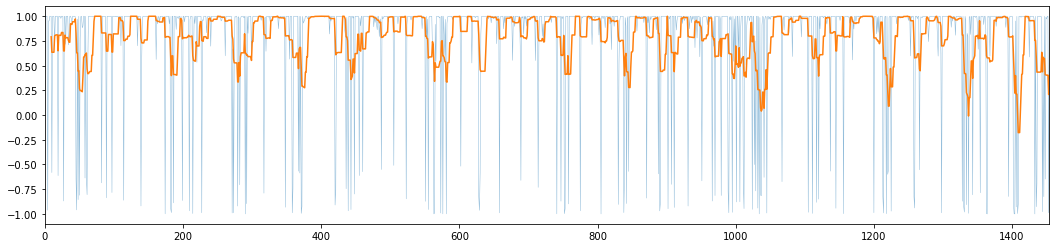


-------------------------------------------------------------------------------

words


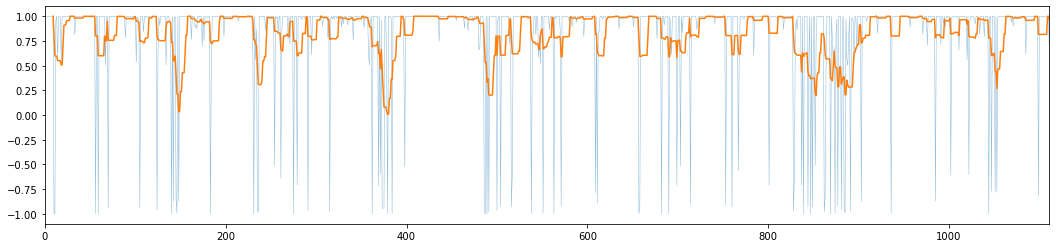


-------------------------------------------------------------------------------

oath


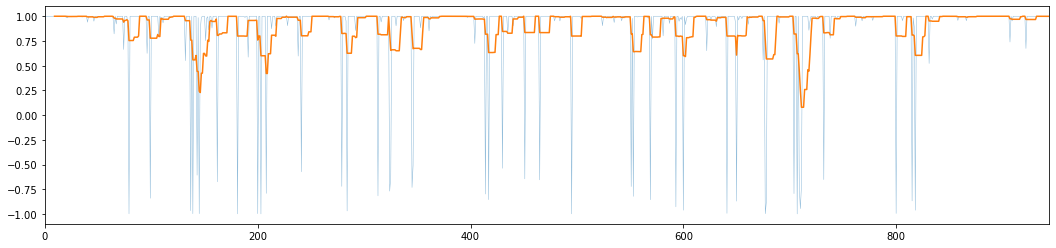


-------------------------------------------------------------------------------

edge


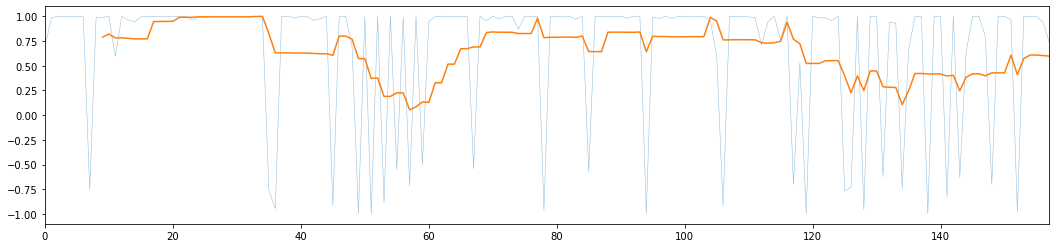


-------------------------------------------------------------------------------

war


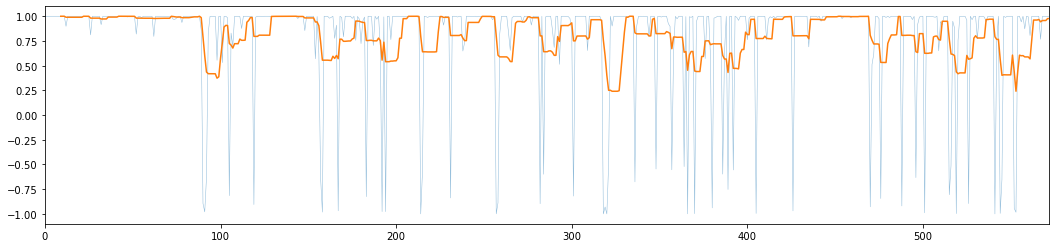


-------------------------------------------------------------------------------



In [567]:
for k, v in d4.items():
    print(k)
    v.score.plot(figsize=(18, 4), alpha=.5, lw=.5)
    v.score.rolling(10).mean().plot()
    plt.show()
    print(spacer())

kings


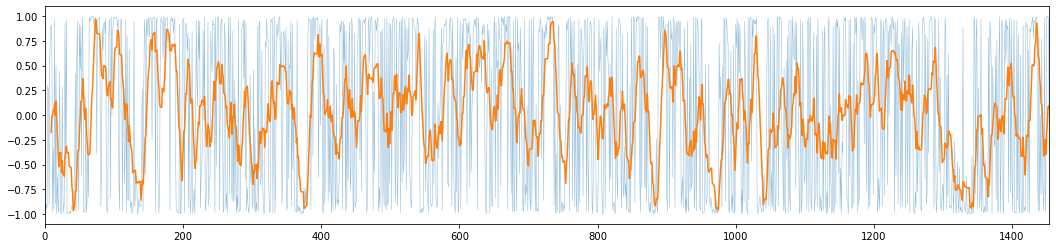


-------------------------------------------------------------------------------

words


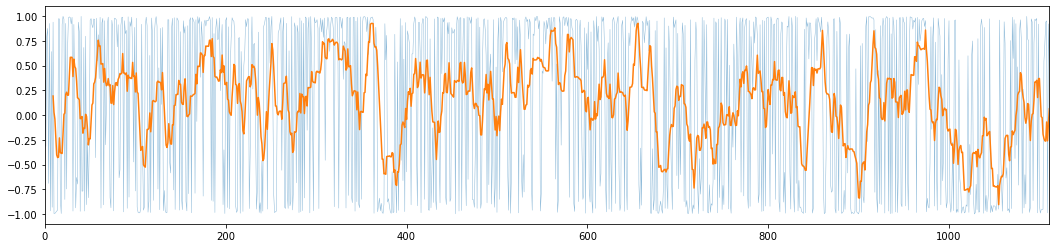


-------------------------------------------------------------------------------

oath


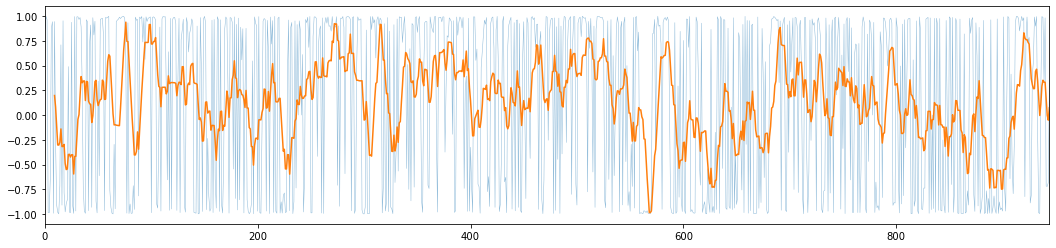


-------------------------------------------------------------------------------

edge


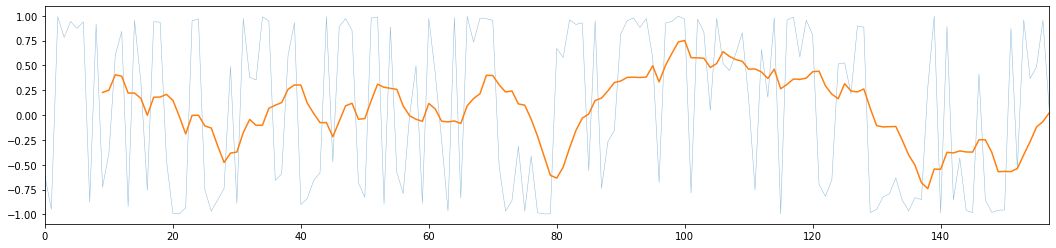


-------------------------------------------------------------------------------

war


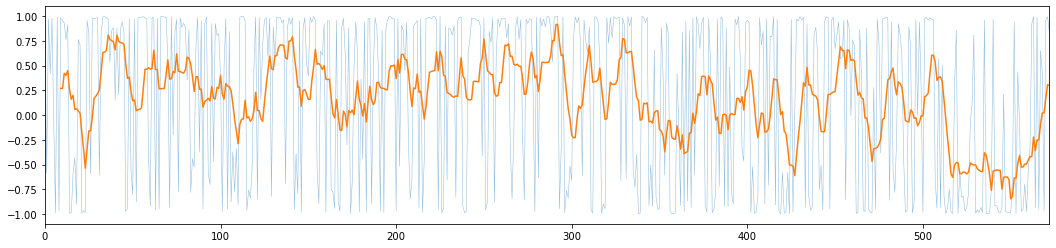


-------------------------------------------------------------------------------



In [568]:
for k, v in d.items():
    print(k)
    v.score.plot(figsize=(18, 4), alpha=.5, lw=.5)
    v.score.rolling(10).mean().plot()
    plt.show()
    print(spacer())

kings


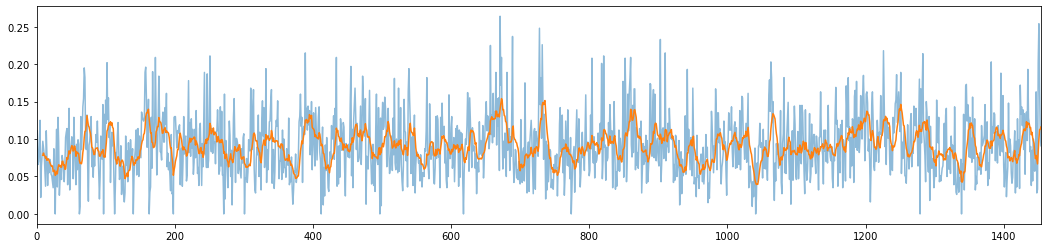


-------------------------------------------------------------------------------

words


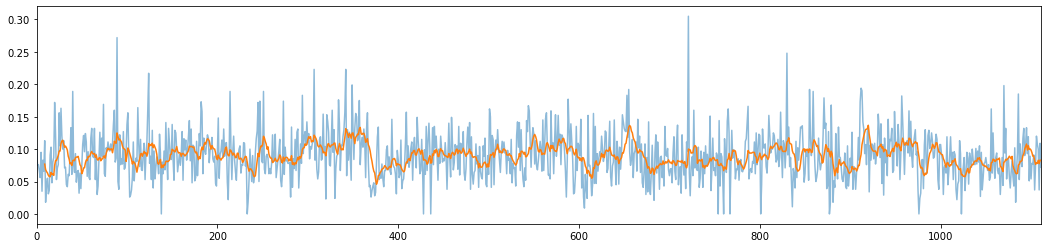


-------------------------------------------------------------------------------

oath


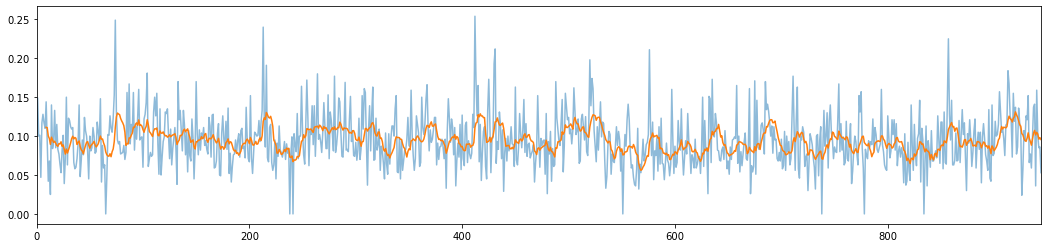


-------------------------------------------------------------------------------

edge


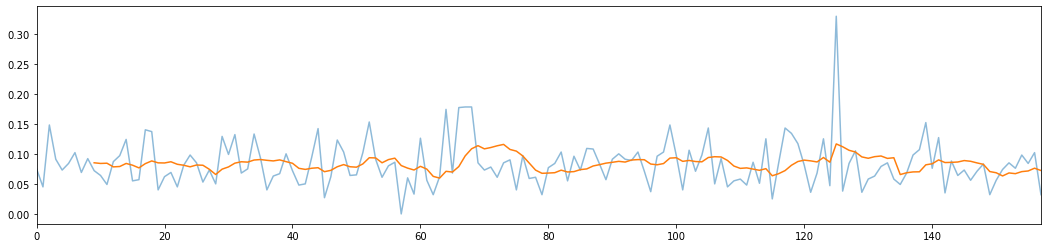


-------------------------------------------------------------------------------

war


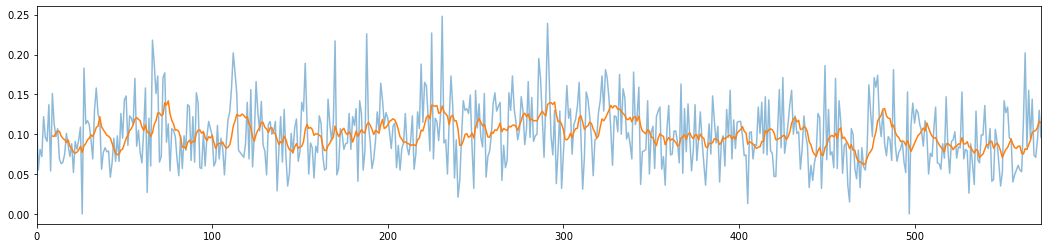


-------------------------------------------------------------------------------



In [569]:
for k, v in d.items():
    print(k)
    v.pos.plot(figsize=(18, 4), alpha=.5)
    v.pos.rolling(10).mean().plot()
    plt.show()
    print(spacer())

kings


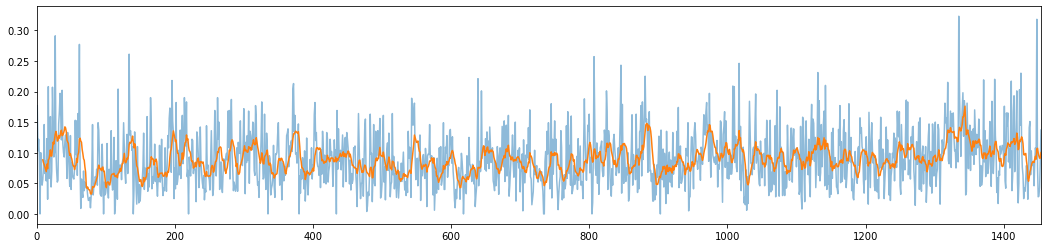


-------------------------------------------------------------------------------

words


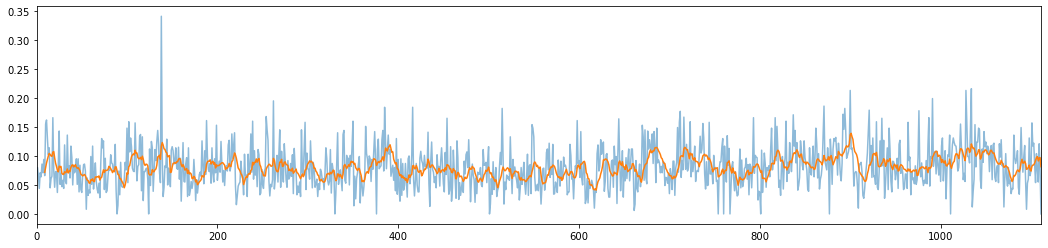


-------------------------------------------------------------------------------

oath


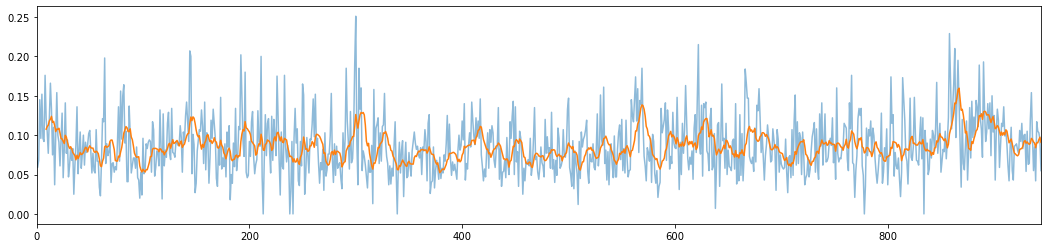


-------------------------------------------------------------------------------

edge


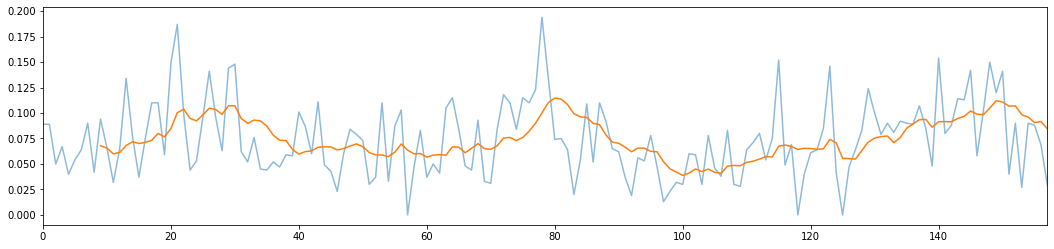


-------------------------------------------------------------------------------

war


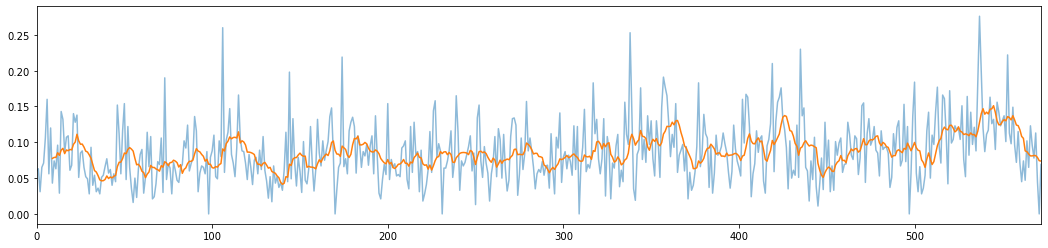


-------------------------------------------------------------------------------



In [570]:
for k, v in d.items():
    print(k)
    v.neg.plot(figsize=(18, 4), alpha=.5)
    v.neg.rolling(10).mean().plot()
    plt.show()
    print(spacer())

kings


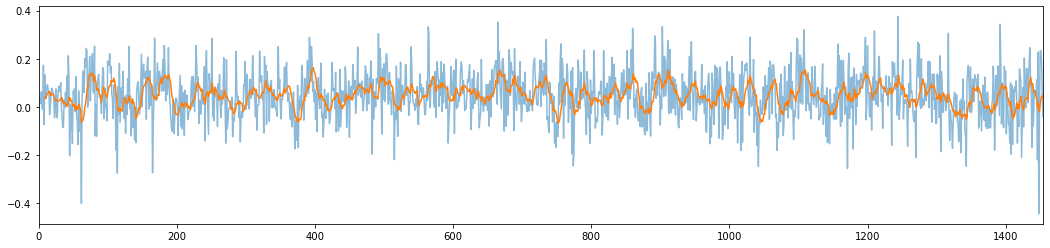


-------------------------------------------------------------------------------

words


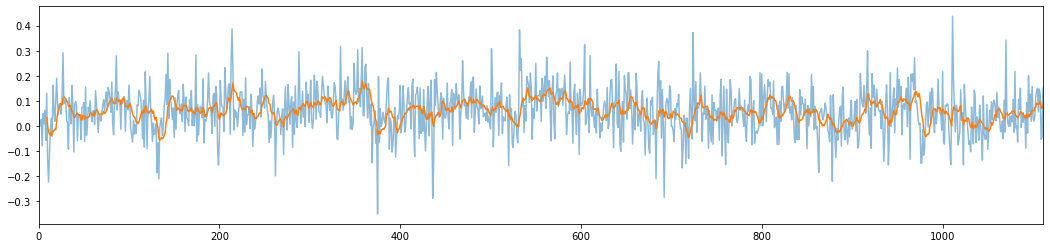


-------------------------------------------------------------------------------

oath



-------------------------------------------------------------------------------

edge



-------------------------------------------------------------------------------

war



-------------------------------------------------------------------------------



In [571]:
for k, v in d2.items():
    print(k)
    v.score.plot(figsize=(18, 4), alpha=.5)
    v.score.rolling(10).mean().plot()
    plt.show()
    print(spacer())

kings



-------------------------------------------------------------------------------

words



-------------------------------------------------------------------------------

oath


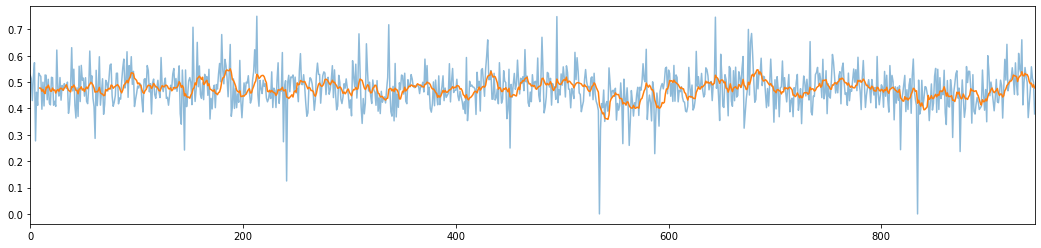


-------------------------------------------------------------------------------

edge



-------------------------------------------------------------------------------

war


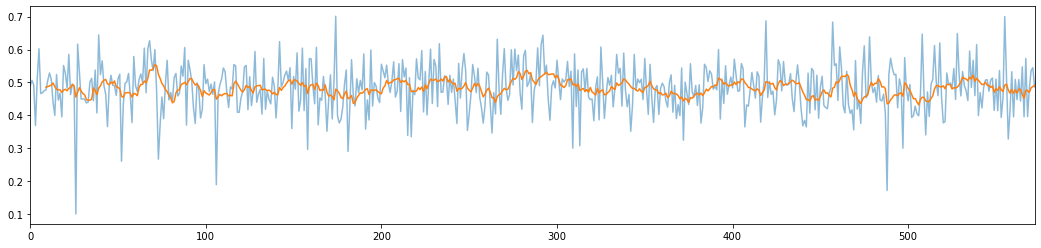


-------------------------------------------------------------------------------



In [572]:
for k, v in d2.items():
    print(k)
    v.subjectivity.plot(figsize=(18, 4), alpha=.5)
    v.subjectivity.rolling(10).mean().plot()
    plt.show()
    print(spacer())

In [579]:
for d_ in (d, d2, d3, d4):
    d_['kings'].score.describe().pprint()

In [576]:
d2['kings'].score.describe()

count    1455.000000
mean        0.048698
std         0.100058
min        -0.443878
25%        -0.011841
50%         0.047394
75%         0.112252
max         0.376603
Name: score, dtype: float64

In [528]:
tmp = lmap(tpipe, *[t+'.' for t in books.war.split('.')[:20] if t.split()])
[t[0]['score'] for t in tmp]

[0.9979994297027588,
 0.9076806902885437,
 0.9922381043434143,
 0.9935854077339172,
 0.9849348068237305,
 0.9994314312934875,
 0.9994310140609741,
 0.9979679584503174,
 0.9865732192993164,
 0.6959334015846252,
 0.9978770613670349,
 0.984004557132721,
 0.9955256581306458,
 0.9835560321807861,
 0.9883137345314026,
 0.9322035908699036,
 0.9978429079055786,
 0.9955053329467773,
 0.9972583651542664]

kings


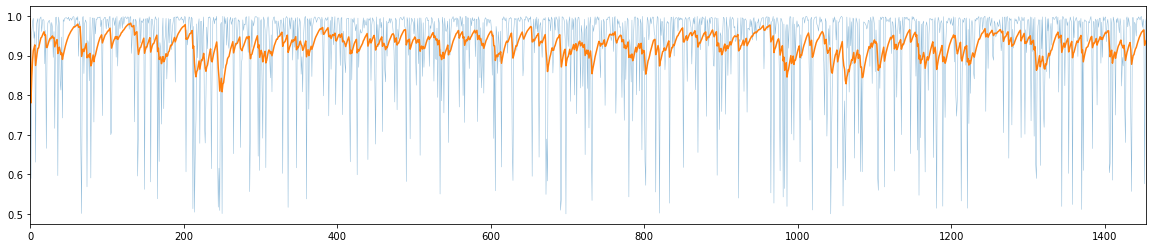


-------------------------------------------------------------------------------

words


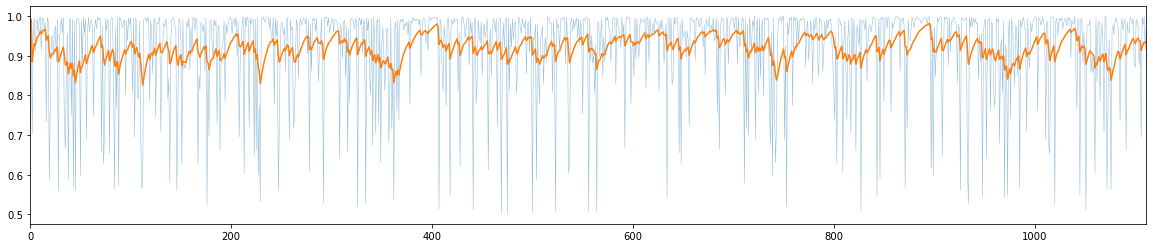


-------------------------------------------------------------------------------

oath


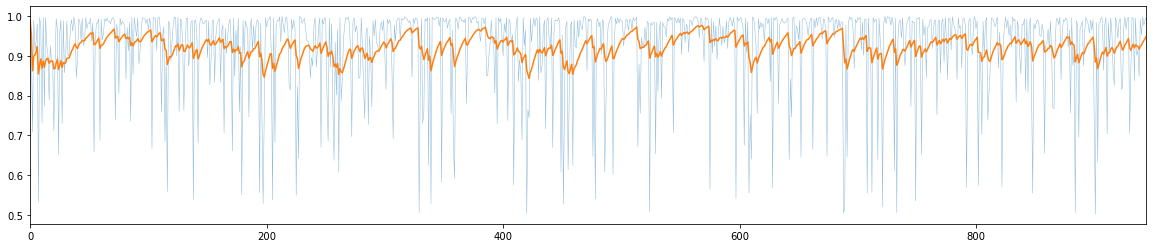


-------------------------------------------------------------------------------

edge



-------------------------------------------------------------------------------

war



-------------------------------------------------------------------------------



In [577]:
for k, df in d3.items():
    print(k)
    df.score.plot(figsize=(20, 4), alpha=.5, lw=.5)
    df.score.ewm(alpha=.1).mean().plot(figsize=(20, 4))
    plt.show()
    print(spacer())

kings


words


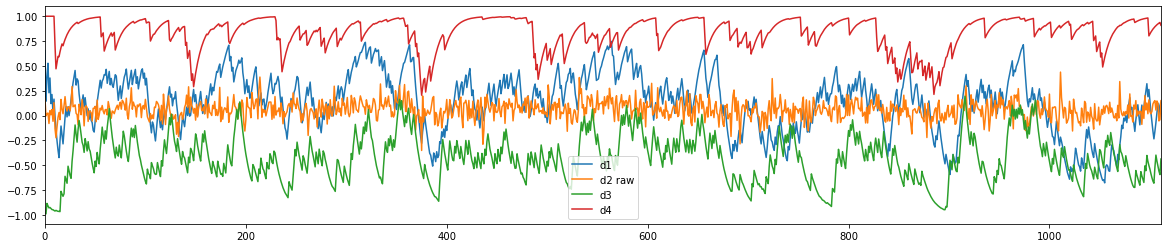

oath


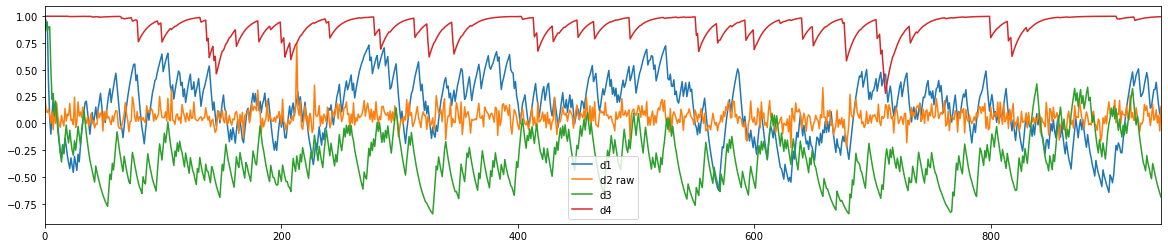

edge


war


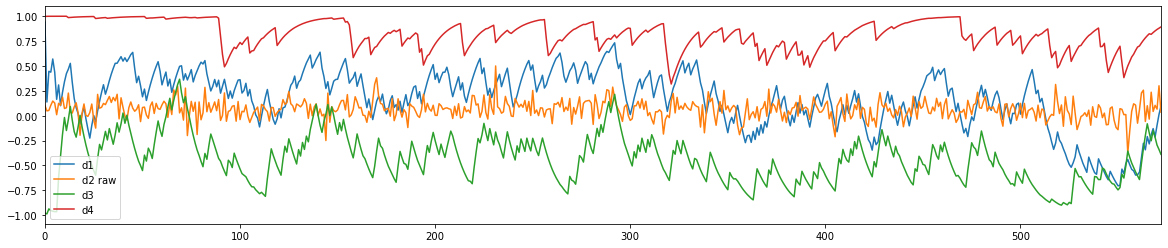

In [515]:
for k, df in d.items():
    print(k)
    df['compound'].ewm(alpha=.1).mean().plot(figsize=(20, 4), label='d1')
    d2[k].polarity.plot(label='d2 raw')
    d3[k].score.ewm(alpha=.1).mean().plot(label='d3')
    d4[k].score.ewm(alpha=.1).mean().plot(label='d4')
    plt.legend()
    plt.show()

In [447]:
plt.hist([d_['compound'] for d_ in sum(scores.values(), [])])
plt.show()

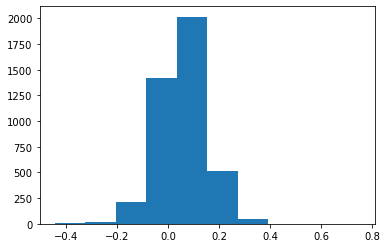

In [446]:
plt.hist([d_['polarity'] for d_ in sum(scores2.values(), [])])
plt.show()

In [445]:
plt.hist([d_['score'] for d_ in sum(scores3.values(), [])])
plt.show()

In [502]:
d4['edge'].score

0      0.689548
1      0.982503
2      0.999999
3      1.000000
4      0.999682
         ...   
153    1.000000
154    0.999879
155    0.999171
156    0.942695
157    0.734339
Name: score, Length: 158, dtype: float64

In [513]:
plt.hist(flatten(d_['score'].values for d_ in chain(d4.values())))
plt.show()

In [514]:
for k, df in d.items():
    print(k)
    print(df['compound'].autocorr().round(3), 
          d2[k].polarity.autocorr().round(3),
          d3[k].score.autocorr().round(3),
          d4[k].score.autocorr().round(3))

kings
0.233 0.145 0.143 0.094
words
0.137 0.165 0.078 0.086
oath
0.151 0.133 0.083 0.063
edge
0.202 0.214 0.01 -0.088
war
0.161 0.11 0.145 0.179


In [365]:
save(scores3, 'data/interim/distilbert_sentiment_scores.pkl')

Writing data to data/interim/distilbert_sentiment_scores.pkl.


# Notes [Update: done]:

- Normalize each sentiment score 
    - consider: 
        - fit on each book or all books at once?
        - normalize, minmax scale, quantile transform (-> uniform), power transform (-> normal)?
        - Note: I think they're technically all on the -1 to 1 scale now, but they use that scale very differently. Distilbert's score is a probability, not an intensity, and tends to be near the extremes. TextBlob seems to not use the extremes much at all.
    - add all 3 to get a (hopefully) better sentiment score and re-norm

In [696]:
sent_counts = {name: len(PunktSentenceTokenizer().tokenize(book)) 
               for name, book in books.items()}
sent_counts

{'kings': 39441, 'words': 46592, 'oath': 46022, 'edge': 5501, 'war': 21931}

In [697]:
page_counts = {name: len(book.split(BREAK)) for name, book in books.items()}
page_counts

{'kings': 1457, 'words': 1114, 'oath': 947, 'edge': 160, 'war': 576}

In [703]:
{k: v/page_counts[k] for k, v in sent_counts.items()}

{'kings': 27.070006863417984,
 'words': 41.824057450628366,
 'oath': 48.597676874340024,
 'edge': 34.38125,
 'war': 38.07465277777778}

In [705]:
# Avg. sentences per page
sum(sent_counts.values()) / sum(page_counts.values())

37.49106723084156

In [709]:
fgrep(books.oath, 'strode over', 250)

'he air like the sensation of lightning about to strike.\n"Who?"\n"Highprince Torol Sadeas, sir," the woman said. "He\'s been murdered."\nxxbrxxI needed to write it anyway.\n--From Oathbringer, preface\n"Stop! What do you think you\'re doing?" Adolin Kholin strode over to a group of workers in cremstained work outfits who were unloading boxes from the back of a wagon. Their chull twisted, trying\nto search out rockbuds to munch on. Fruitlessly. They were deep within the tower, for all the fact that\nthis '